TF-IDF method for scoring - only on testing as there is no model behind it that needs to be trained

# Libraries

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.2 MB/s 
     |████████████████████████████████| 212 kB 43.4 MB/s 
     |████████████████████████████████| 132 kB 45.5 MB/s 
     |████████████████████████████████| 182 kB 11.6 MB/s 
     |████████████████████████████████| 127 kB 40.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import list_datasets, load_dataset

# Print all the available datasets
ds = load_dataset('mlsum', 'es')

Generating train split:   0%|          | 0/266367 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10358 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13920 [00:00<?, ? examples/s]

Dataset mlsum downloaded and prepared to /root/.cache/huggingface/datasets/mlsum/es/1.0.0/033c69bbbf1eb198d444f668be75f297cb86251c0671a3d063d1c53c2f231076. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
!pip install rouge_score
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=81f2b798e769145b27d6c55236d8fc174d4421f2581b70c49ecd678632a5a3d9
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.1 MB/s 


In [ ]:
#import tensorflow as tf
#import tensorflow_datasets as tfds
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
#from rouge import Rouge
from ast import literal_eval
import re
import math

from datasets import list_datasets, load_dataset

import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Function for TF - IDF (taken from https://towardsdatascience.com/text-summarization-using-tf-idf-e64a0644ace3)
def create_frequency_matrix(sentences):
    frequency_matrix = {}
    stopWords = set(stopwords.words('spanish'))
    ps = nltk.stem.porter.PorterStemmer()

    for sent in sentences:
        freq_table = {}
        sent = re.sub(r'[^\w\s]', '', sent)
        words = nltk.word_tokenize(sent)
        for word in words:
            word = word.lower()
            word = ps.stem(word)
            if word in stopWords:
                continue

            if word in freq_table:
                freq_table[word] += 1
            else:
                freq_table[word] = 1
            if freq_table:
              frequency_matrix[sent[:15]] = freq_table
            else: continue

    return frequency_matrix

In [ ]:
def create_tf_matrix(freq_matrix):
    tf_matrix = {}

    for sent, f_table in freq_matrix.items():
        tf_table = {}

        count_words_in_sentence = len(f_table)
        for word, count in f_table.items():
            tf_table[word] = count / count_words_in_sentence

        tf_matrix[sent] = tf_table

    return tf_matrix

In [ ]:
def create_documents_per_words(freq_matrix):
    word_per_doc_table = {}

    for sent, f_table in freq_matrix.items():
        for word, count in f_table.items():
            if word in word_per_doc_table:
                word_per_doc_table[word] += 1
            else:
                word_per_doc_table[word] = 1

    return word_per_doc_table

In [ ]:
def create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
    idf_matrix = {}

    for sent, f_table in freq_matrix.items():
        idf_table = {}

        for word in f_table.keys():
            idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))

        idf_matrix[sent] = idf_table

    return idf_matrix

In [ ]:
def create_tf_idf_matrix(tf_matrix, idf_matrix):
    tf_idf_matrix = {}

    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):

        tf_idf_table = {}

        for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
            tf_idf_table[word1] = float(value1 * value2)

        tf_idf_matrix[sent1] = tf_idf_table

    return tf_idf_matrix

In [ ]:
def score_sentences_f(tf_idf_matrix) -> dict:
    """
    score a sentence by its word's TF
    Basic algorithm: adding the TF frequency of every non-stop word in a sentence divided by total no of words in a sentence.
    :rtype: dict
    """

    sentenceValue = {}

    for sent, f_table in tf_idf_matrix.items():
        total_score_per_sentence = 0

        count_words_in_sentence = len(f_table)
        for word, score in f_table.items():
            total_score_per_sentence += score

        sentenceValue[sent] = total_score_per_sentence / count_words_in_sentence

    return sentenceValue

In [ ]:
def find_average_score(sentenceValue) -> int:
    """
    Find the average score from the sentence value dictionary
    :rtype: int
    """
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original summary_text
    average = (sumValues / len(sentenceValue))

    return average

In [ ]:
def generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:15] in sentenceValue and sentenceValue[sentence[:15]] >= (threshold):
            summary += " " + sentence
            sentence_count += 1

    return summary

In [ ]:
import time
a = time.time()

# Data

Due to time it takes, tensorflow data was downloaded and saved as csv for iteration process to take less time

In [ ]:
ds = load_dataset('mlsum', 'es')
df = pd.DataFrame(ds["test"])
df_validation = pd.DataFrame(ds["validation"])
df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

(13920, 6)

In [ ]:
df.head()

,text,summary,topic,url,title,date
0,"Despedida de Rajoy, tras perder la votación de...","Doce meses después de la moción de censura, su...",politica actualidad,http://elpais.com/politica/2019/05/31/actualid...,Un año de la carambola que lo cambió todo,01/06/2019
1,Si no puede ver la retransmisión del desfile e...,Los Reyes presiden este sábado el desfile de l...,politica actualidad,http://elpais.com/politica/2019/05/31/actualid...,Día de las Fuerzas Armadas: Sevilla homenajea ...,01/06/2019
2,Cocina como si danzara. Da pasos grandes y más...,La tradicional receta de Senegal se creó en la...,elpais planeta_futuro,http://elpais.com/elpais/2019/03/26/planeta_fu...,"‘Ceebu jën’, el plato de los cuatro continentes",01/06/2019
3,Una escena de la película 'RocketMan'. En víde...,‘Bohemian Rhapsody’ y ‘Rocketman’ prefiguran o...,elpais gente,http://elpais.com/elpais/2019/05/31/gente/1559...,"Si cantas y no tienes ‘biopic’, no eres nadie",01/06/2019
4,"Impecable en estilo y formas, Amadou Diaw (Dak...",Amadou Diaw es una persona clave en el desarro...,elpais planeta_futuro,http://elpais.com/elpais/2019/05/28/planeta_fu...,“En África sopla un nuevo viento: las mujeres ...,01/06/2019


# EDA

In [ ]:
# Length of text
def text_length(df):
  df["words_article"] = df["text"].apply(lambda n: len(n.split()))
  df["words_summary"] = df["summary"].apply(lambda n: len(n.split()))
  df["summary_perc"] = df["words_summary"]/df["words_article"] 
  return df

df = text_length(df)

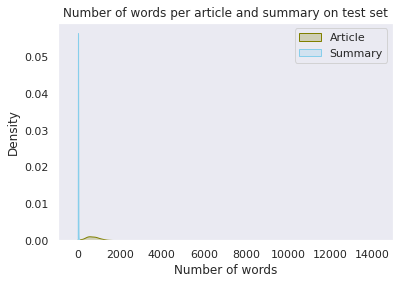

Average number of words in article: 783.925790229885 and in summary: 21.919827586206896


In [ ]:
# Plots
sns.set(style="darkgrid")
fig = sns.kdeplot(df['words_article'], shade=True, color="olive", label='Article')
fig = sns.kdeplot(df['words_summary'], shade=True, color="skyblue", label='Summary')
plt.title("Number of words per article and summary on test set")
plt.legend()
plt.grid(False)
plt.xlabel("Number of words")
plt.show()
print("Average number of words in article: {} and in summary: {}".format(df['words_article'].mean(), df['words_summary'].mean()))

In [ ]:
df[['words_article', 'words_summary']].describe() # 21 words! 

,words_article,words_summary
count,13920.00000,13920.000000
mean,783.92579,21.919828
std,573.95292,7.326019
min,50.00000,10.000000
25%,479.00000,17.000000
50%,704.00000,21.000000
75%,965.25000,26.000000
max,14004.00000,89.000000


# Data Prep

In [ ]:
# Tokenization
tokenize_article = df["text"].apply(nltk.sent_tokenize).reset_index().drop(columns=["index"])
tokenize_article_validation = df_validation["text"].apply(nltk.sent_tokenize).reset_index().drop(columns=["index"])


In [ ]:
# Create count of sentences considered as "documents" for this dataset
tokenize_article["total_sentences"] = tokenize_article["text"].apply(len)
tokenize_article_validation["total_sentences"] = tokenize_article_validation["text"].apply(len)

In [ ]:
tokenize_article_validation["total_sentences"].describe()

count    10358.000000
mean        32.146264
std         26.489439
min          1.000000
25%         17.000000
50%         27.000000
75%         40.000000
max        649.000000
Name: total_sentences, dtype: float64

# Analysis 1: TF-IDF

In [ ]:
# Calculate Freq matrix
from tqdm import tqdm
tqdm.pandas()
freq_matrix = tokenize_article["text"].progress_apply(create_frequency_matrix)
freq_matrix_validation = tokenize_article_validation["text"].progress_apply(create_frequency_matrix)

freq_matrix


100%|██████████| 10358/10358 [03:03<00:00, 56.52it/s]


0        {'Despedida de Ra': {'despedida': 1, 'rajoy': ...
1        {'Si no puede ver': {'si': 1, 'pued': 1, 'ver'...
2        {'Cocina como si ': {'cocina': 1, 'si': 1, 'da...
3        {'Una escena de l': {'escena': 1, 'película': ...
4        {'Impecable en es': {'impec': 1, 'estilo': 1, ...
                               ...                        
13915    {'El dolor tiene ': {'dolor': 1, 'tien': 1, 'c...
13916    {'En algún lugar ': {'algún': 1, 'lugar': 1, '...
13917    {'Antes de conver': {'ant': 1, 'convertirs': 1...
13918    {'La novela de la': {'novela': 1, 'mexicana': ...
13919    {'Todo va mal  Mu': {'va': 2, 'mal': 1, 'mucha...
Name: text, Length: 13920, dtype: object

In [ ]:
# Term Freq Matrix
tqdm.pandas()
tf_matrix = freq_matrix.progress_apply(create_tf_matrix)
tf_matrix_validation = freq_matrix_validation.progress_apply(create_tf_matrix)
tf_matrix

100%|██████████| 10358/10358 [00:01<00:00, 7198.62it/s]


0        {'Despedida de Ra': {'despedida': 0.1111111111...
1        {'Si no puede ver': {'si': 0.1, 'pued': 0.1, '...
2        {'Cocina como si ': {'cocina': 0.3333333333333...
3        {'Una escena de l': {'escena': 0.3333333333333...
4        {'Impecable en es': {'impec': 0.04166666666666...
                               ...                        
13915    {'El dolor tiene ': {'dolor': 0.07142857142857...
13916    {'En algún lugar ': {'algún': 0.06666666666666...
13917    {'Antes de conver': {'ant': 0.0769230769230769...
13918    {'La novela de la': {'novela': 0.1111111111111...
13919    {'Todo va mal  Mu': {'va': 0.13333333333333333...
Name: text, Length: 13920, dtype: object

In [ ]:
# Create table for docs per words
tqdm.pandas()
docs_per_words = freq_matrix.progress_apply(create_documents_per_words)
docs_per_words_validation = freq_matrix_validation.progress_apply(create_documents_per_words)

docs_per_words

100%|██████████| 10358/10358 [00:01<00:00, 9947.32it/s] 


0        {'despedida': 1, 'rajoy': 6, 'tra': 2, 'perder...
1        {'si': 1, 'pued': 1, 'ver': 1, 'retransmisión'...
2        {'cocina': 3, 'si': 2, 'danzara': 1, 'da': 2, ...
3        {'escena': 1, 'película': 4, 'rocketman': 2, '...
4        {'impec': 1, 'estilo': 1, 'forma': 1, 'amad': ...
                               ...                        
13915    {'dolor': 6, 'tien': 1, 'cosa': 1, 'magnífica'...
13916    {'algún': 1, 'lugar': 2, 'ciudad': 3, 'vieja':...
13917    {'ant': 1, 'convertirs': 2, 'mantra': 1, 'bipa...
13918    {'novela': 7, 'mexicana': 5, 'luisa': 3, 'jose...
13919    {'va': 3, 'mal': 1, 'mucha': 1, 'sal': 1, 'bie...
Name: text, Length: 13920, dtype: object

In [ ]:
# Calculate IDF
idf_matrix = pd.Series(np.nan, index = np.arange(docs_per_words.shape[0]))
position = 0
for i in tqdm(range(docs_per_words.shape[0])):
  idf_matrix[position] = str(create_idf_matrix(freq_matrix[i],
  docs_per_words[i],
  tokenize_article["total_sentences"][i]))
  position += 1

idf_matrix = idf_matrix.progress_apply(literal_eval)
idf_matrix

100%|██████████| 13920/13920 [00:36<00:00, 380.26it/s]


0        {'Despedida de Ra': {'despedida': 1.6532125137...
1        {'Si no puede ver': {'si': 1.146128035678238, ...
2        {'Cocina como si ': {'cocina': 1.3357921019231...
3        {'Una escena de l': {'escena': 1.7403626894942...
4        {'Impecable en es': {'impec': 1.97312785359969...
                               ...                        
13915    {'El dolor tiene ': {'dolor': 0.56427143043856...
13916    {'En algún lugar ': {'algún': 1.56820172406699...
13917    {'Antes de conver': {'ant': 1.1760912590556813...
13918    {'La novela de la': {'novela': 0.9402317949965...
13919    {'Todo va mal  Mu': {'va': 1.3290587192642247,...
Length: 13920, dtype: object

In [ ]:
# Validation
idf_matrix_validation = pd.Series(np.nan, index = np.arange(docs_per_words_validation.shape[0]))
position = 0
for i in tqdm(range(docs_per_words_validation.shape[0])):
  idf_matrix_validation[position] = str(create_idf_matrix(freq_matrix_validation[i],
  docs_per_words_validation[i],
  tokenize_article_validation["total_sentences"][i]))
  position += 1

idf_matrix_validation = idf_matrix_validation.progress_apply(literal_eval)

100%|██████████| 10358/10358 [00:26<00:00, 384.86it/s]


In [ ]:
# Calculate TF IDF
tf_idf_matrix = pd.Series({}, index = np.arange(docs_per_words.shape[0]))
position = 0
for i in tqdm(range(docs_per_words.shape[0])):
  tf_idf_matrix[position] = str(create_tf_idf_matrix(tf_matrix[i],
  idf_matrix[i]))
  position += 1

tf_idf_matrix = tf_idf_matrix.progress_apply(literal_eval)
tf_idf_matrix


<ipython-input-29-1d4f3ebedbfb>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tf_idf_matrix = pd.Series({}, index = np.arange(docs_per_words.shape[0]))
100%|██████████| 13920/13920 [00:38<00:00, 366.22it/s]


0        {'Despedida de Ra': {'despedida': 0.1836902793...
1        {'Si no puede ver': {'si': 0.1146128035678238,...
2        {'Cocina como si ': {'cocina': 0.4452640339743...
3        {'Una escena de l': {'escena': 0.5801208964980...
4        {'Impecable en es': {'impec': 0.08221366056665...
                               ...                        
13915    {'El dolor tiene ': {'dolor': 0.04030510217418...
13916    {'En algún lugar ': {'algún': 0.10454678160446...
13917    {'Antes de conver': {'ant': 0.0904685583888985...
13918    {'La novela de la': {'novela': 0.1044701994440...
13919    {'Todo va mal  Mu': {'va': 0.17720782923522996...
Length: 13920, dtype: object

In [ ]:
# Validation
tf_idf_matrix_validation = pd.Series({}, index = np.arange(docs_per_words_validation.shape[0]))
position = 0
for i in tqdm(range(docs_per_words_validation.shape[0])):
  tf_idf_matrix_validation[position] = str(create_tf_idf_matrix(tf_matrix_validation[i],
  idf_matrix_validation[i]))
  position += 1

tf_idf_matrix_validation = tf_idf_matrix_validation.progress_apply(literal_eval)

<ipython-input-30-2423ad8120e3>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tf_idf_matrix_validation = pd.Series({}, index = np.arange(docs_per_words_validation.shape[0]))
100%|██████████| 10358/10358 [00:26<00:00, 389.50it/s]


In [ ]:
# Score sentences
score_sentences = tf_idf_matrix.progress_apply(score_sentences_f)
score_sentences_validation = tf_idf_matrix_validation.progress_apply(score_sentences_f)
score_sentences


100%|██████████| 10358/10358 [00:00<00:00, 21894.86it/s]


0        {'Despedida de Ra': 0.13937267120646732, 'En v...
1        {'Si no puede ver': 0.10984159102062716, 'Sevi...
2        {'Cocina como si ': 0.517843202171658, 'Da pas...
3        {'Una escena de l': 0.4797775646100875, 'En ví...
4        {'Impecable en es': 0.06658422261731982, 'Es e...
                               ...                        
13915    {'El dolor tiene ': 0.10407949819952896, 'El d...
13916    {'En algún lugar ': 0.08237937598257176, 'Su d...
13917    {'Antes de conver': 0.08512483065521843, 'Paul...
13918    {'La novela de la': 0.15574586977614788, 'La e...
13919    {'Todo va mal  Mu': 0.12073993699519654, 'cant...
Length: 13920, dtype: object

In [ ]:
# Threshold 
avg_score = score_sentences_validation.progress_apply(find_average_score)
avg_score

100%|██████████| 10358/10358 [00:00<00:00, 136292.08it/s]


0        0.091002
1        0.119056
2        0.032457
3        0.159326
4        0.091071
           ...   
10353    0.149782
10354    0.047006
10355    0.047257
10356    0.147962
10357    0.141104
Length: 10358, dtype: float64

In [ ]:
# Define a fixed threshold
#threshold = avg_score.quantile(0.75)
threshold_l = [avg_score.quantile(0.25), avg_score.quantile(0.5), avg_score.quantile(0.75), avg_score.quantile(0.9)]

In [ ]:
# Select best threshold
import evaluate

list_rouge = []
for threshold in threshold_l:
  summary_df_validation = pd.Series({}, index = np.arange(docs_per_words_validation.shape[0]))
  position = 0
  for i in tqdm(range(docs_per_words_validation.shape[0])):
    summary_df_validation[position] = generate_summary(tokenize_article_validation["text"][i],
    score_sentences_validation[i], threshold)
    position += 1
  y_validation = df_validation["summary"]
  y_pred = summary_df_validation
  rouge_score = evaluate.load("rouge")
  dic_temp = rouge_score.compute(predictions=y_pred, references=y_validation)

  list_rouge.append(dic_temp)

print(list_rouge)

<ipython-input-34-fdad6cd95512>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_df_validation = pd.Series({}, index = np.arange(docs_per_words_validation.shape[0]))
100%|██████████| 10358/10358 [00:00<00:00, 22091.84it/s]


100%|██████████| 10358/10358 [00:00<00:00, 25526.64it/s]


[{'rouge1': 0.11909758847529266, 'rouge2': 0.036570969574947015, 'rougeL': 0.08903569475845764, 'rougeLsum': 0.08909408891495821}, {'rouge1': 0.12732649085016168, 'rouge2': 0.029272860047481503, 'rougeL': 0.09275604571162287, 'rougeLsum': 0.09274667983161528}, {'rouge1': 0.11287225935733011, 'rouge2': 0.01977355886579206, 'rougeL': 0.0824241613754601, 'rougeLsum': 0.08248925974281437}, {'rouge1': 0.08590984444542132, 'rouge2': 0.0121294853015181, 'rougeL': 0.06436695880004281, 'rougeLsum': 0.06439335699350869}]


In [ ]:
# Pick best on f1 to apply to test
f1 = [d['rougeL'] for d in list_rouge]
print(f1)
threshold = threshold_l[np.argmax(f1)]
print("threshold:", threshold)

[0.08903569475845764, 0.09275604571162287, 0.0824241613754601, 0.06436695880004281]
threshold: 0.13993467732494153


# Performance metrics

In [ ]:
# Generate summarization
summary_df = pd.Series({}, index = np.arange(docs_per_words.shape[0]))
position = 0
for i in tqdm(range(docs_per_words.shape[0])):
  summary_df[position] = generate_summary(tokenize_article["text"][i],
  score_sentences[i], threshold)
  position += 1

#summary_df = summary_df.progress_apply(literal_eval)
summary_df

<ipython-input-36-c62225d26857>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_df = pd.Series({}, index = np.arange(docs_per_words.shape[0]))
100%|██████████| 13920/13920 [00:00<00:00, 22277.64it/s]


0         Pero en la semana que tardó en fraguarse, las...
1                                                         
2         Cocina como si danzara. Mueve la cabeza y cie...
3         Una escena de la película 'RocketMan'. Pero e...
4         Es el espíritu de la teranga senegalesa que é...
                               ...                        
13915     El dolor es tal vez el sentimiento más comple...
13916     La Biblia Kennicott es un indicio del rico pa...
13917                Alarmante es la actualidad de Galdós.
13918     La novela de la mexicana Luisa Josefina Herná...
13919     canta en Vivir es Deber, de su último disco V...
Length: 13920, dtype: object

In [ ]:
y_test = df["summary"]
y_pred = summary_df

In [ ]:
rouge_score = evaluate.load("rouge")
rouge_score.compute(predictions=y_pred, references=y_test)

# {'rouge1': 0.12463381868889697,
#  'rouge2': 0.026969053004482477,
#  'rougeL': 0.090161083735719,
#  'rougeLsum': 0.09015128906307532}

{'rouge1': 0.12463381868889697,
 'rouge2': 0.026969053004482477,
 'rougeL': 0.090161083735719,
 'rougeLsum': 0.09015128906307532}

In [ ]:
b= time.time()
print("Minutes to finish running:", (b - a)/60)

Minutes to finish running: 14.864119756221772


In [ ]:
# EXAMPLES: 

In [ ]:
y_test[0]

'Doce meses después de la moción de censura, sus protagonistas, que entonces dudaron, ven claro que fue un acierto'

In [ ]:
y_pred[0]

' Pero en la semana que tardó en fraguarse, las cosas se parecían mucho más a la carambola de un billar descontrolado. Y se le alinearon. Ninguno de los protagonistas de esa vertiginosa carambola está arrepentido. Pero siempre fuimos claros con ellos”, recuerda Esteban. La sentencia de Gürtel cayó como una bomba”, remata el portavoz del PNV. Ahora todo se ve muy claro. Especialmente desde La Moncloa. Pero en ese momento todo eran dudas. Albert Rivera era el favorito, el hombre fuerte. Con su inesperada llegada a La Moncloa, Sánchez dio un vuelco total a la situación. Desde el viernes [una semana antes de la votación] tenía muy claro lo que teníamos que hacer. Los partidos que podíamos votar a favor no teníamos razón para abstenernos. Podemos estaba obligado. ERC ya lo había dicho. Nosotros teníamos que estar. Pero en realidad contribuimos a crear un bloque social progresista que ahora se ve en el CIS. Si se alarga dos o tres semanas, se habría complicado. La clave es que [la moción] no

In [ ]:
df['text'][0]

'Despedida de Rajoy, tras perder la votación de la moción de censura hace un año. En vídeo, así fue la votación de la moción de censura que convirtió a Pedro Sánchez en presidente del Gobierno. Foto: D. GAGO | Vídeo: ATLAS Vista un año después, la moción de censura que cambió la historia de España parece ajedrez, todo calculado. Pero en la semana que tardó en fraguarse, las cosas se parecían mucho más a la carambola de un billar descontrolado. “A Sánchez se le tenían que alinear los planetas para ser presidente. Y se le alinearon. Y eso que venía de las catacumbas”, recuerda, con su habitual humor, Aitor Esteban, portavoz en el Congreso del PNV, el partido clave para la salida de Rajoy, al que solo ocho días antes había apuntalado aprobándole los presupuestos. Ninguno de los protagonistas de esa vertiginosa carambola está arrepentido. A pesar de que a algunos, como Marta Pascal y Carles Campuzano, del PDeCAT, les costó su carrera política la osadía de torcerle el brazo a Carles Puigdem